In [1]:
import numpy as np 
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

In [2]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/churchland.npy') 
X = jnp.array(X) 
print(X.shape)

(108, 218, 61)


In [26]:
def single_pair_loss(U_tilde, X, id_1, id_2):                           #U (N,d); X(K,N,T)
    Y = jnp.einsum('i,kl->kil', U_tilde[id_1, :], X[:, id_1, :])        #(K,d,T)
    Y_prime = jnp.einsum('i,kl->kil', U_tilde[id_2, :], X[:, id_2, :])

    YY = jnp.einsum('kdt,klt->kdl', Y, Y_prime)                         #(K,d,d)
    YY_product = jnp.einsum('kij,klm->kim', YY, YY)

    S_pair = jnp.trace(YY, axis1=1, axis2=2)**2 - jnp.trace(YY_product, axis1=1, axis2=2)
    return S_pair

def loss(U, X, seed=0):  
    K, N, T = X.shape
    U_tilde, _ = jnp.linalg.qr(U)

    num_pairs = 1000  
    key = random.PRNGKey(seed)
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, 0, 0))(U_tilde, X, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs, K)

    S = jnp.mean(2 / (K**2) * jnp.sum(batched_loss,axis=0))
    return -S

grad_loss = grad(loss)

def init_adam_optimizer(U_initial, learning_rate=0.001):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(U_initial)
    return optimizer, opt_state

def update_U(U, X, optimizer, opt_state):
    dL_dU = grad_loss(U, X)
    updates, opt_state_updated = optimizer.update(dL_dU, opt_state, U)
    U_updated = optax.apply_updates(U, updates)
    return U_updated, opt_state_updated

def optimize_U(X, iterations=1000, learning_rate=0.001, d=3):
    K, N, T = X.shape
    key = random.PRNGKey(0)
    U = random.normal(key, (N, d))

    optimizer, opt_state = init_adam_optimizer(U, learning_rate)

    for i in range(iterations):
        U, opt_state = update_U(U, X, optimizer, opt_state)
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss(U, X)}")
    
    return U

optimized_U = optimize_U(X)                     #optimized_U (N,d)

Iteration 0, S: 303.034912109375
Iteration 10, S: 374.0216979980469
Iteration 20, S: 446.0478820800781
Iteration 30, S: 520.3441772460938
Iteration 40, S: 598.1541748046875
Iteration 50, S: 680.7645874023438
Iteration 60, S: 769.5540161132812
Iteration 70, S: 866.077392578125
Iteration 80, S: 972.1229858398438
Iteration 90, S: 1089.745361328125
Iteration 100, S: 1221.3221435546875
Iteration 110, S: 1369.6583251953125
Iteration 120, S: 1538.1405029296875
Iteration 130, S: 1730.9310302734375
Iteration 140, S: 1953.1973876953125
Iteration 150, S: 2211.39306640625
Iteration 160, S: 389.8141784667969
Iteration 170, S: 681.4365844726562
Iteration 180, S: 1016.6827392578125
Iteration 190, S: 1373.3525390625
Iteration 200, S: 1757.0794677734375
Iteration 210, S: 2181.071533203125
Iteration 220, S: 2661.732666015625
Iteration 230, S: 3218.513671875
Iteration 240, S: 3874.904541015625
Iteration 250, S: 4659.619140625
Iteration 260, S: 5607.6630859375
Iteration 270, S: 6761.3583984375
Iteration 2

In [27]:
np.save('optimized_U_test_3', optimized_U)

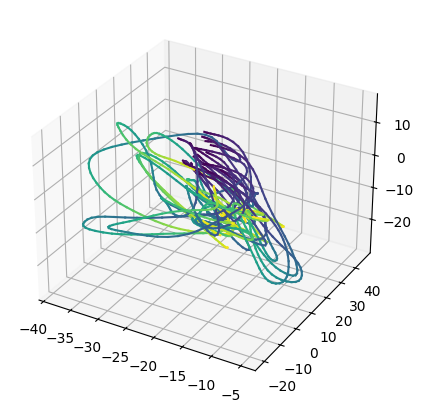

In [33]:
optimized_U_tilde, _ = jnp.linalg.qr(optimized_U)
Y = jnp.einsum('ji,kjl->kil', optimized_U_tilde, X)   


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('viridis')

num_time_points = Y.shape[-1]
indices_to_plot = np.arange(0,Y.shape[0],5)  #[1,2,3,4,-1,-2,-3,-4]

for i in indices_to_plot:
    x = Y[i, 0, :]  
    y = Y[i, 1, :] 
    z = Y[i, 2, :]  
    
    for t in range(num_time_points - 1):
        ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))

# def make_frame(angle):
#     ax.view_init(30, angle)
#     fig.canvas.draw()  # Redraw the figure (this is necessary for updating the plot's appearance)
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     return image

# angles = range(0, 360, 2)  # Adjust step for smoother or faster rotation
# frames = [make_frame(angle) for angle in angles]

# gif_path = "trajectories_rotation_test3.gif"
# imageio.mimsave(gif_path, frames, fps=20)

# gif_path
